#### 导入库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

#### 数据导入

In [2]:
data = pd.read_csv('park_info_with_grids.csv')  # 数据加载
data = data.fillna(0)
data.head()

,Unnamed: 0,geometry,grid_id,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,nearest_residential_distance,...,nearest_park_distance,distance_to_nearest_bike_network,POP_DENSITY,EMPLOYED_PERCENTAGE,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE,TOTAL_AREA,TYPE
0,0,"POLYGON ((-13607990.19116259 6023951.23868917,...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,POLYGON ((-13608506.81627558 6023962.862982571...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,"POLYGON ((-13608682.76518992 6023966.61165225,...",2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,POLYGON ((-13610206.44615618 6023341.900384837...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,POLYGON ((-13608853.09858667 6024384.237879843...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
from shapely import wkt
data['geometry'] = data['geometry'].apply(wkt.loads)

In [4]:
#保存几何信息
geometry = data['geometry'].copy()

<Axes: >

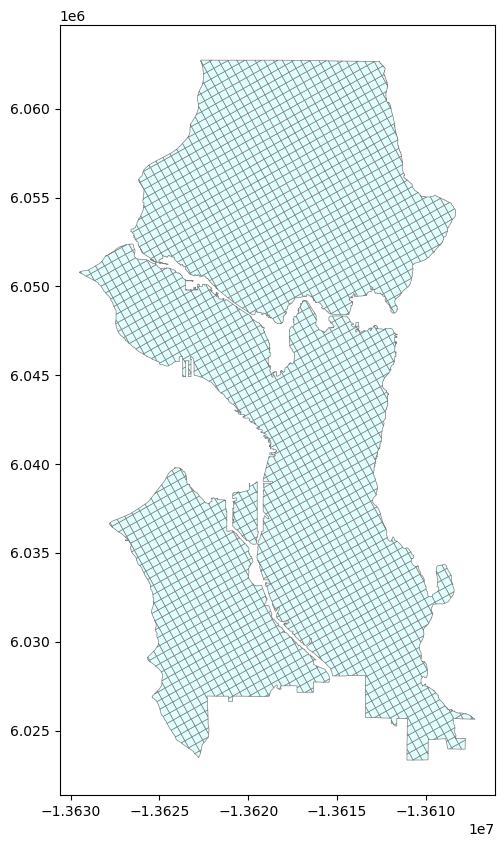

In [11]:
import geopandas as gpd
val_preds_df =  gpd.GeoDataFrame(data,geometry='geometry')
fig,ax = plt.subplots(1,1,figsize = (10,10))
val_preds_df.plot(facecolor = 'lightcyan',edgecolor = 'grey',linewidth = 0.5,ax = ax)

#### 数据处理

In [12]:
features = val_preds_df.drop(columns = ['TOTAL_AREA','TYPE','Unnamed: 0','geometry','grid_id'])
target = val_preds_df['TOTAL_AREA'] # 'TYPE'
target = target.values # 将y转为NumPy数组
target

array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
features.head()

,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,nearest_residential_distance,nearest_MHA_distance,nearest_metro_distance,nearest_school_distance,nearest_landmark_distance,nearest_park_distance,distance_to_nearest_bike_network,POP_DENSITY,EMPLOYED_PERCENTAGE,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# 数据标准化 拟合+缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
# 在机器学习中，特征缩放是提高性能的关键预处理步骤，StandardScaler 是 sklearn.preprocessing 模块中的一个类，它可以将特征缩放到均值为 0，标准差为 1。
# fit_transform 方法是 StandardScaler 类的一个重要方法，它结合了 fit 和 transform 两个操作。
# fit 方法用于计算数据的统计信息，如均值和标准差，这些统计信息将用于后续的缩放操作。
# transform 方法则使用 fit 方法计算得到的统计信息对数据进行实际的缩放。
# fit_transform 方法将这两个步骤合并为一个操作，它首先对输入的数据进行拟合，计算出均值和标准差，然后直接使用这些统计信息对数据进行缩放，并返回缩放后的数据。

In [15]:
# 把X_scaled转化为dataframe
X_scaled_df = pd.DataFrame(X_scaled,index = features.index,columns = features.columns) # index很重要,数据用index相连
X_scaled_df.head()

,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,nearest_residential_distance,nearest_MHA_distance,nearest_metro_distance,nearest_school_distance,nearest_landmark_distance,nearest_park_distance,distance_to_nearest_bike_network,POP_DENSITY,EMPLOYED_PERCENTAGE,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE
0,-0.389281,-0.319058,-0.429846,-0.399273,-0.419164,-0.168845,-0.608528,-0.508828,-0.619201,-0.722231,-0.699216,-0.518118,-0.52743,-0.702589,-0.90898,-0.856174,-0.865807,-0.844318,-0.766271
1,-0.389281,-0.319058,-0.429846,-0.399273,-0.419164,-0.168845,-0.608528,-0.508828,-0.619201,-0.722231,-0.699216,-0.518118,-0.52743,-0.702589,-0.90898,-0.856174,-0.865807,-0.844318,-0.766271
2,-0.389281,-0.319058,-0.429846,-0.399273,-0.419164,-0.168845,-0.608528,-0.508828,-0.619201,-0.722231,-0.699216,-0.518118,-0.52743,-0.702589,-0.90898,-0.856174,-0.865807,-0.844318,-0.766271
3,-0.389281,-0.319058,-0.429846,-0.399273,-0.419164,-0.168845,-0.608528,-0.508828,-0.619201,-0.722231,-0.699216,-0.518118,-0.52743,-0.702589,-0.90898,-0.856174,-0.865807,-0.844318,-0.766271
4,-0.389281,-0.319058,-0.429846,-0.399273,-0.419164,-0.168845,-0.608528,-0.508828,-0.619201,-0.722231,-0.699216,-0.518118,-0.52743,-0.702589,-0.90898,-0.856174,-0.865807,-0.844318,-0.766271


#### 数据分割

In [16]:
# 分割数据
X_train,X_test,y_train,y_test = train_test_split(X_scaled_df,target,test_size = 0.4,random_state = 42)
# 特征数据Features通常可以是 numpy.ndarray 、pandas.DataFrame 等类型。numpy.ndarray 是一个多维数组，常用于存储数值型数据。pandas.DataFrame 是一个二维表格型数据结构，每列可以有不同的数据类型，并且可以有列名，方便对数据进行操作和管理。
# 目标变量Target通常可以是 numpy.ndarray 或 pandas.Series 。numpy.ndarray 可以存储目标变量的数值。pandas.Series 是一维带标签的数组，它可以和 pandas.DataFrame 中的特征数据更好地对应。

#### 超参数优化

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import PoissonRegressor

# 定义模型
rf_model = RandomForestRegressor()
xgb_model = XGBRegressor()
poi_model = PoissonRegressor(max_iter = 1000)
xp_model = XGBRegressor()

# 定义参数
rf_param_grid = {'n_estimators':[100,200,300],'max_depth':[None,10,20]}
xgb_param_grid = {'n_estimators':[100,200,300],'max_depth':[3,6,10]}
poi_param_grid = {'alpha':[0,1,1,10]} # alpha:正则化强度的系数
xp_param_grid = {'n_estimators':[100,200,300],'max_depth':[None,10,20]}

# 寻找最佳参数
## a.获取一个使用网格搜索策略进行超参数调优的对象(GridSearchCV对象)
# GridSearchCV 是一个用于超参数优化的工具，它通过系统地遍历指定的超参数网格，来寻找最佳的模型参数组合。
# 超参数优化：GridSearchCV 可以自动搜索给定参数网格中的所有组合，以找到性能最佳的参数集。这些参数是模型在训练过程中需要调节的，而不是模型学习的参数。
# 交叉验证：GridSearchCV 使用交叉验证来评估每个超参数组合的性能。这意味着它将数据分成若干折，在每一折上进行训练和验证，以确保模型性能的可靠性。
# 模型选择：通过评估不同超参数组合下的模型表现，GridSearchCV 可以选择表现最佳的模型，并提供相应的超参数配置。
rf_grid_search = GridSearchCV(rf_model,rf_param_grid,scoring = 'r2',cv = 10)
xgb_grid_search = GridSearchCV(xgb_model,xgb_param_grid,scoring = 'r2',cv = 10)
poi_grid_search = GridSearchCV(poi_model,poi_param_grid,scoring = 'r2',cv = 10)
xp_grid_search = GridSearchCV(xp_model,xp_param_grid,scoring = 'r2',cv = 10)
# 在GridSearchCV函数中，scoring参数用于指定模型评估的指标。当设置为scoring='r2'时，意味着使用R²得分（决定系数）来评估模型在交叉验证过程中的性能。
# 在GridSearchCV函数中，cv = 10表示使用10折交叉验证（10-fold cross-validation）来评估模型在不同超参数组合下的性能。
# cv = 10:在10折交叉验证中，数据集会被平均分成10个部分，每次选择其中一个部分作为验证集，另外9个部分作为训练集，这样会进行10次训练和验证过程，最终将这10次的评估结果进行平均，得到该超参数组合下模型的性能指标。
# 使用交叉验证可以更稳定、更准确地评估模型的性能，避免因数据集划分的随机性而导致评估结果的偏差。在GridSearchCV中使用10折交叉验证，能够在不同的超参数组合下，更全面地评估模型的性能，从而选出最优的超参数组合。

## b.fit方法会用训练数据X_train和标签y_train来训练模型
# 对于GridSearchCV,它会在每个超参数组合上进行模型训练,然后通过交叉验证来评估模型性能,并选择性能最佳的参数组合
rf_grid_search.fit(X_train,y_train)
xgb_grid_search.fit(X_train,y_train)
poi_grid_search.fit(X_train,y_train)
xp_grid_search.fit(X_train,y_train)

# 获取最佳模型 | 完成搜索后，GridSearchCV 可以提供表现最好的模型及其对应的超参数配置，通常通过 best_estimator_ 属性访问
rf_best_model = rf_grid_search.best_estimator_
xgb_best_model = xgb_grid_search.best_estimator_
poi_best_model = poi_grid_search.best_estimator_
xp_best_model = xp_grid_search.best_estimator_

#### K Fold Cross Validation

In [32]:
# 空间K折划分
from sklearn.model_selection import KFold
# KFold 是一个用于将数据集划分为 k 个不重叠子集的工具，常用于交叉验证，在机器学习中，交叉验证是一种评估模型性能的常用方法，可有效利用有限的数据进行模型评估 
def spatial_k_fold(X,y,n_splits = 5):
    kf = KFold(n_splits = n_splits)
    # 这行代码创建了一个 KFold 对象 kf，并使用参数 n_splits 来指定要将数据集划分为多少个不重叠的子集
    splits = []
    # 这行代码创建了一个空列表 splits，用于存储每次划分得到的训练集和验证集的索引。
    for train_index,val_index in kf.split(X): 
    # 这行代码使用 kf.split(X) 方法对输入的数据集 X 进行划分，该方法返回一个生成器，每次迭代会产生一对索引：train_index 和 val_index，分别表示训练集和验证集的索引
        splits.append((train_index,val_index))
        # 这行代码将每次划分得到的训练集和验证集的索引作为一个元组 (train_index, val_index) 添加到列表 splits 中
    return splits

# 在代码 for i, (train_index, val_index) in enumerate(splits): 
# val_index 代表验证集的索引，它的来源与 splits 列表的生成有关。通常 splits 是通过交叉验证方法生成的，
# 以 KFold 为例，它会将数据集划分为 k 个不重叠的子集，在每次迭代中，其中 k - 1 个子集作为训练集，剩下的 1 个子集作为验证集。


# 交叉验证
def cross_validate(X,y,model,n_splits = 5):
    metrics_list = [] # 初始化一个空列表，用于存储每次交叉验证得到的评估指标 
    preds_list = [] # 初始化一个空列表，用于存储每次交叉验证得到的预测结果
    splits = spatial_k_fold(X,y,n_splits = n_splits) # 调用上面的空间K折划分,获得由元组 (train_index, val_index) 组成的列表 splits

    for i,(train_index,val_index) in enumerate(splits): # 带索引标签的元组,标签和原X,y一样的标签,index非常重要
    # enumerate() 是 Python 的一个内置函数，用于将一个可迭代对象（如列表、元组或字符串）组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。
    # 当使用 enumerate(splits) 时，splits 是由 spatial_k_fold 函数生成的列表，该列表包含多个元组，每个元组包含训练集和验证集的索引。
    # enumerate(splits) 会为 splits 列表中的每个元素分配一个索引，从 0 开始递增。
        X_train_cv,X_val_cv = X.iloc[train_index],X.iloc[val_index] 
        # 根据索引从原始特征矩阵 X 中提取训练集和验证集的特征,因为X是DataFrame,所以引用每行是加iloc
        y_train_cv,y_val_cv = y[train_index],y[val_index] 
        # 根据索引从原始标签向量 y 中提取训练集和验证集的标签,y是array数组,引用不需要iloc

        preds,metrics = train_and_evaluate(X_train_cv,y_train_cv,X_val_cv,y_val_cv,model)
        # 调用 train_and_evaluate 函数，传入训练集和验证集的数据以及模型，得到预测结果和评估指标
        metrics_list.append(metrics)

        # 获得OOF预测结果 | # 创建一个 DataFrame，用于存储本次交叉验证的真实标签、预测标签、模型名称和当前折数
        # OOF 预测值常用于模型性能评估，尤其是在交叉验证过程中，能够更准确地估计模型在未见过的数据上的表现
        # OOF 更能反映模型的真实性能，特别是在评估模型的泛化能力时非常有用
        preds_df = pd.DataFrame({
            'true':y_val_cv, # 'true' 列存储的是验证集的真实标签 y_val_cv一般是验证集的标签数据，它来源于真实世界的观测或者记录，是客观存在的事实
            'pred':preds # 'pred' 列存储的是模型对验证集的预测结果 preds
        }) # 模型评估需要将预测结果与真实值进行对比，以确定模型的性能
        preds_df['model'] = model.__class__.__name__ # 将模型的类名赋值给 preds_df 的 model 列
        # __class__ 是 Python 中每个对象都有的一个特殊属性，它返回该对象所属的类。例如，如果 model 是一个 RandomForestClassifier 实例，那么 model.__class__ 就会返回 RandomForestClassifier 这个类。
        # model.__class__.__name__：__name__ 是类对象的一个属性，它返回类的名称，以字符串的形式呈现。例如，对于 RandomForestClassifier 类，model.__class__.__name__ 会返回字符串 'RandomForestClassifier'。
        preds_df['fold'] = i # 在 DataFrame 中添加一列，记录当前是第几折交叉验证
        preds_list.append(preds_df) 
        # 多模型预测结果收集：当使用多个不同的机器学习模型进行预测时(比如现在是k折)，
        # 每个模型的预测结果可以存储在一个 DataFrame 中，然后将这些 DataFrame 依次添加到 preds_list 中。这样可以方便地对所有模型的预测结果进行比较和分析

    return metrics_list,pd.concat(preds_list)
    # pd.concat(preds_list) : 将多个k折获得的 OOF预测结果DataFrame 垂直堆叠在一起


# 模型训练和评估函数
def train_and_evaluate(X_train,y_train,X_test,y_test,model):
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    metrics = {
        'RMSE':np.sqrt(mean_squared_error(y_test,preds)),
        'MAE':mean_absolute_error(y_test,preds),
        'MAPE':mean_absolute_percentage_error(y_test,preds),
        'RSQ':r2_score(y_test,preds)
    }
    return preds,metrics

def evaluate_models(X_train,y_train,X_test,y_test):
    models = {
        'rf':rf_best_model,
        'xgb':xgb_best_model,
        'poi':poi_best_model,
        'xp':xp_best_model
    }
    # 用前面的最佳模型组成字典,然后每个模型进行测试
    
    metrics_list = []
    predictions_df_list = {}
    predictions_index_list = {}
    oof_predictions = {}

    for name,model in models.items(): # 遍历 models 字典中的每个键值对 | eg.name-'rf',model-rf_best_model 
        print(f'Evaluating model : {name}')
        # 交叉验证
        metrics_list_cv,oof_preds = cross_validate(X_train,y_train,model)
        # 调用 cross_validate 函数对当前模型进行交叉验证，返回评估指标列表 metrics_list_cv 和 out-of-fold 预测结果 oof_preds
        avg_metrics = pd.DataFrame(metrics_list_cv).mean().to_dict() 
        # 将交叉验证得到的评估指标列表转换为 DataFrame，计算均值，并转换为字典
        avg_metrics['model'] = name 
        # 在平均评估指标字典中添加模型名称  eg.name-'rf',model-rf_best_model 
        metrics_list.append(avg_metrics)

        # 训练 为了获取直接预测结果
        final_preds,_ = train_and_evaluate(X_train,y_train,X_test,y_test,model)

        # 检查最终预测结果的长度是否与真实标签 y_test 的长度一致，如果不一致则抛出 ValueError 异常。
        if len(final_preds) != len(y_test):
            raise ValueError(f"Length of predictions for model '{name}' does not match y_test length.")
        
        # final 预测结果
        final_preds_df = pd.DataFrame({
            'true': y_test,
            'pred': final_preds,
            'model': name
        },index = X_test.index) # 将真实标签、最终预测结果和模型名称组合成一个 DataFrame。
        predictions_df_list[name] = final_preds_df # 将该 DataFrame 添加到 predictions_df_list 字典中，键为模型名称。
        
        oof_predictions[name] = oof_preds # 收集OOF预测结果 字典

    final_predictions_df = pd.concat(predictions_df_list.values())
    metrics_df = pd.DataFrame(metrics_list)

    return metrics_df, final_predictions_df, oof_predictions
    # 返回评估指标的 DataFrame、最终预测结果的 DataFrame 和 out-of-fold 预测结果的字典。

In [33]:
metrics_df,final_predictions_df,oof_predictions = evaluate_models(X_train, y_train, X_test, y_test)

# 打印指标
print(metrics_df)

# 打印最终预测结果
print(final_predictions_df)

# 打印各模型的 OOF 预测结果
for model_name, oof_df in oof_predictions.items():
    print(f"OOF predictions for {model_name}:")
    print(oof_df)

Evaluating model : rf
Evaluating model : xgb
Evaluating model : poi
Evaluating model : xp
          RMSE          MAE          MAPE       RSQ model
0  5769.872595  2084.826583  1.088242e+00  0.260051    rf
1  6168.623155  2109.540249  2.683280e+14  0.157319   xgb
2  6159.036688  2242.250853  1.342004e+17  0.146080   poi
3  6168.623155  2109.540249  2.683280e+14  0.157319    xp
       true         pred model
840     0.0     0.000000    rf
2233    0.0     0.000000    rf
443   408.0  1309.668593    rf
836     0.0     0.000000    rf
2588  327.0   327.109039    rf
...     ...          ...   ...
883     0.0     0.437139    xp
2128    0.0     0.437139    xp
2003    0.0     0.437139    xp
886     0.0     0.437139    xp
1269    0.0     0.437139    xp

[4284 rows x 3 columns]
OOF predictions for rf:
      true        pred                  model  fold
0      0.0    0.000000  RandomForestRegressor     0
1    488.0  874.099198  RandomForestRegressor     0
2      0.0    0.000000  RandomForestRegress

#### 模型评估和选择 – 模型总体误差对比

In [34]:
rf_preds = final_predictions_df[final_predictions_df['model'] == 'rf']['pred'].values
xgb_preds =  final_predictions_df[final_predictions_df['model'] == 'xgb']['pred'].values
poi_preds = final_predictions_df[final_predictions_df['model'] == 'poi']['pred'].values
xp_preds = final_predictions_df[final_predictions_df['model'] == 'xp']['pred'].values

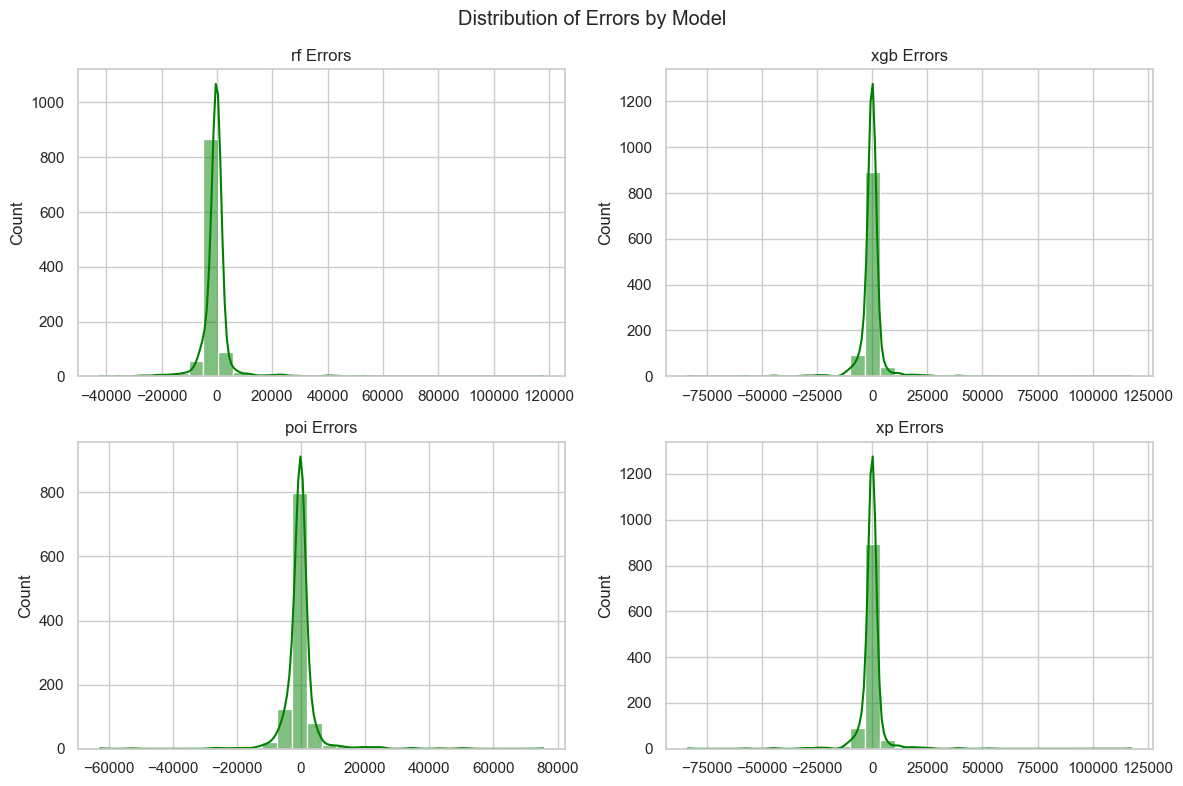

In [39]:
# 模型评估和选择 – 模型总体误差对比
model_names = final_predictions_df['model'].unique()
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, model_name, preds in zip(axes.flatten(),model_names, [rf_preds, xgb_preds, poi_preds, xp_preds]):
    sns.set(style = 'whitegrid',palette = 'crest')
    sns.histplot(y_test - preds, ax=ax, kde=True, bins=30,color = 'green')
    ax.set_title(f'{model_name} Errors')

plt.suptitle('Distribution of Errors by Model')
plt.tight_layout()
plt.show()

在代码 for model_name, df in oof_predictions.items(): ... 里，使用 df['true'] 而非 oof_predictions['true']，是因为 oof_predictions 是一个字典，其键为模型名称，值为包含真实值和预测值的数据结构（通常是 pandas.DataFrame）。oof_predictions 本身并不直接包含 'true' 列，'true' 列是存储在每个模型对应的数据结构 df 里的。

#### 模型评估和选择 – OOF预测对比

In [37]:
# 模型评估和选择 – OOF预测对比
# 计算每个模型的平均评估指标
metrics_list = []
for model_name,df in oof_predictions.items():
    metrics = {
        'model':model_name,
        'MAPE':mean_absolute_percentage_error(df['true'],df['pred']),
        'MAE':mean_absolute_error(df['true'],df['pred']),
        'RMSE':np.sqrt(mean_squared_error(df['true'],df['pred']))
    }
    metrics_list.append(metrics)

# 创建DataFrame
OOF_preds = pd.DataFrame(metrics_list)

In [40]:
OOF_preds

,model,MAPE,MAE,RMSE
0,rf,1.088253e+00,2084.588967,5819.300673
1,xgb,2.682854e+14,2109.270494,6241.453342
2,poi,1.341999e+17,2241.981312,6210.824448
3,xp,2.682854e+14,2109.270494,6241.453342


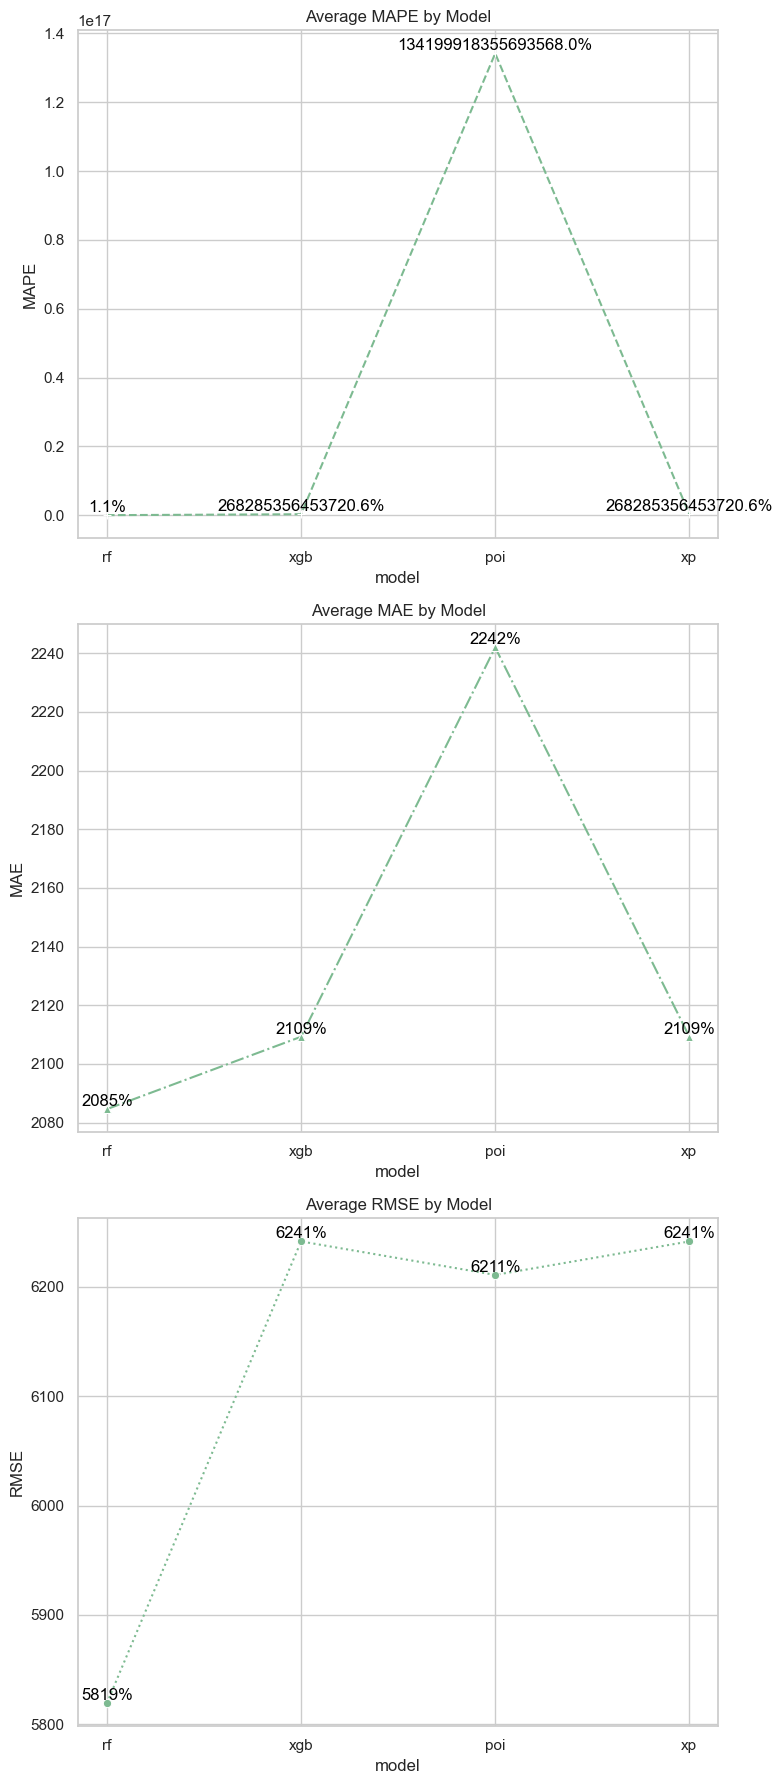

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置颜色和样式
sns.set(style = 'whitegrid',palette = 'crest')

# 创建1*3的图形布局
fig,axes = plt.subplots(nrows = 3,ncols = 1,figsize = (8,18))

# 绘制MAPE图表
sns.lineplot(data=OOF_preds.drop_duplicates(subset = ['model','MAPE']),x = 'model',y = 'MAPE',ax = axes[0],marker = '+',linestyle = '--')
for i in range(len(OOF_preds['model'].unique())):
    axes[0].text(i,OOF_preds.drop_duplicates(subset = ['model','MAPE']).iloc[i]['MAPE'],
                f"{OOF_preds.drop_duplicates(subset=['model', 'MAPE']).iloc[i]['MAPE']:.1f}%", 
                 color='black', ha="center", va="bottom")
axes[0].set_title('Average MAPE by Model')

# 绘制MAE图表
sns.lineplot(data=OOF_preds.drop_duplicates(subset = ['model','MAE']),x = 'model',y = 'MAE',ax = axes[1],marker = '^',linestyle = '-.')
for i in range(len(OOF_preds['model'].unique())):
    axes[1].text(i,OOF_preds.drop_duplicates(subset = ['model','MAE']).iloc[i]['MAE'],
                f"{OOF_preds.drop_duplicates(subset=['model', 'MAE']).iloc[i]['MAE']:.0f}%", 
                 color='black', ha="center", va="bottom")
axes[1].set_title('Average MAE by Model')

# 绘制RMSE图表
sns.lineplot(data=OOF_preds.drop_duplicates(subset = ['model','RMSE']),x = 'model',y = 'RMSE',ax = axes[2],marker = 'o',linestyle = ':')
for i in range(len(OOF_preds['model'].unique())):
    axes[2].text(i,OOF_preds.drop_duplicates(subset = ['model','RMSE']).iloc[i]['RMSE'],
                f"{OOF_preds.drop_duplicates(subset=['model', 'RMSE']).iloc[i]['RMSE']:.0f}%", 
                 color='black', ha="center", va="bottom")
axes[2].set_title('Average RMSE by Model')

# 调整布局
plt.tight_layout()
plt.show()

#### 模型评估和选择 – 实际数据和预测数据的拟合

In [44]:
val_preds = final_predictions_df
val_preds

,true,pred,model
840,0.0,0.000000,rf
2233,0.0,0.000000,rf
443,408.0,1309.668593,rf
836,0.0,0.000000,rf
2588,327.0,327.109039,rf
...,...,...,...
883,0.0,0.437139,xp
2128,0.0,0.437139,xp
2003,0.0,0.437139,xp
886,0.0,0.437139,xp


##### 实际预测对比

In [47]:
# 计算每个模型的指标
metrics = val_preds.groupby('model').apply(
    lambda df: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(df['true'], df['pred'])),
        'MAE': mean_absolute_error(df['true'], df['pred']),
        'MAPE': mean_absolute_percentage_error(df['true'], df['pred']),
        'RSQ': r2_score(df['true'], df['pred'])
    }),include_groups=False
).reset_index()

# 将计算出的指标合并回 val_preds
val_preds = val_preds.merge(metrics, on='model', how='left')

In [48]:
val_preds.head()

,true,pred,model,RMSE,MAE,MAPE,RSQ
0,0.0,0.000000,rf,6355.342385,2043.421037,1.01823,0.270316
1,0.0,0.000000,rf,6355.342385,2043.421037,1.01823,0.270316
2,408.0,1309.668593,rf,6355.342385,2043.421037,1.01823,0.270316
3,0.0,0.000000,rf,6355.342385,2043.421037,1.01823,0.270316
4,327.0,327.109039,rf,6355.342385,2043.421037,1.01823,0.270316


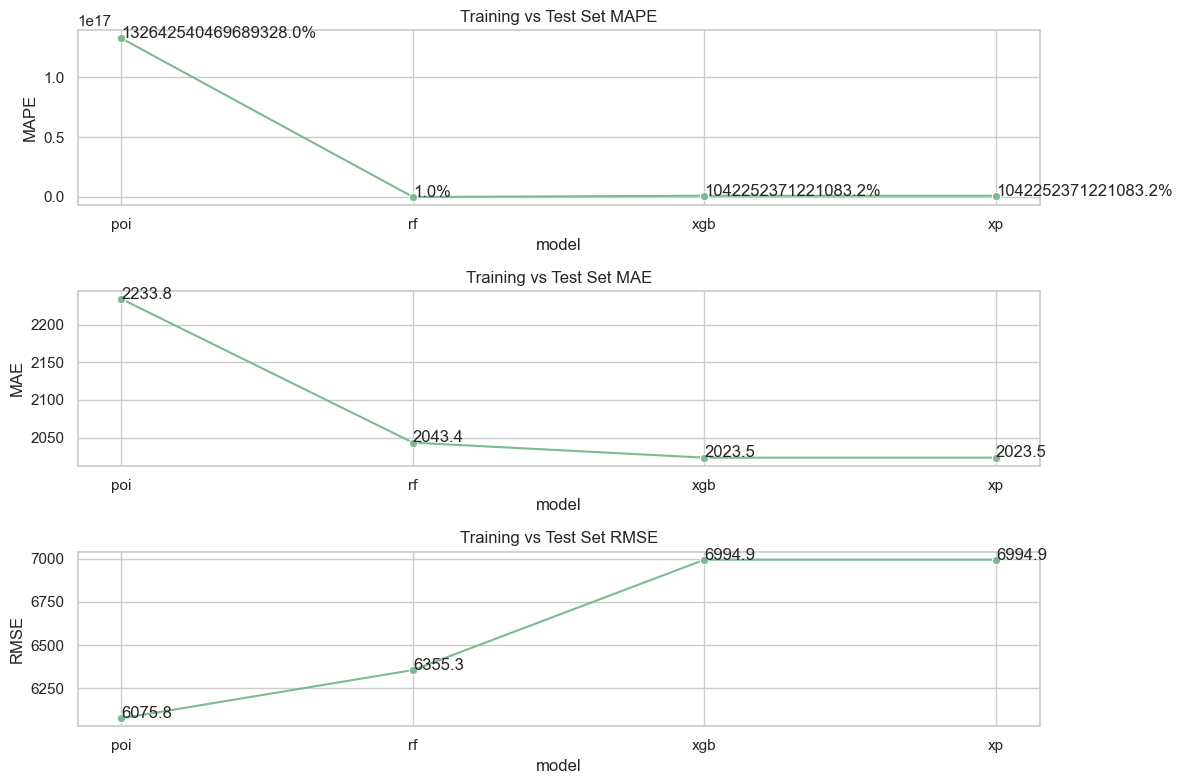

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制 MAPE
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
sns.lineplot(data=metrics, x='model', y='MAPE', marker='o')
for i in range(metrics.shape[0]):
    plt.text(i, metrics.MAPE.iloc[i] + 0.5, f"{metrics.MAPE.iloc[i]:.1f}%")
plt.title("Training vs Test Set MAPE")

# 绘制 MAE
plt.subplot(3, 1, 2)
sns.lineplot(data=metrics, x='model', y='MAE', marker='o')
for i in range(metrics.shape[0]):
    plt.text(i, metrics.MAE.iloc[i] + 0.5, f"{metrics.MAE.iloc[i]:.1f}")
plt.title("Training vs Test Set MAE")

# 绘制 RMSE
plt.subplot(3, 1, 3)
sns.lineplot(data=metrics, x='model', y='RMSE', marker='o')
for i in range(metrics.shape[0]):
    plt.text(i, metrics.RMSE.iloc[i] + 0.5, f"{metrics.RMSE.iloc[i]:.1f}")
plt.title("Training vs Test Set RMSE")

plt.tight_layout()
plt.show()

##### 预测值和实际数据的线性关系

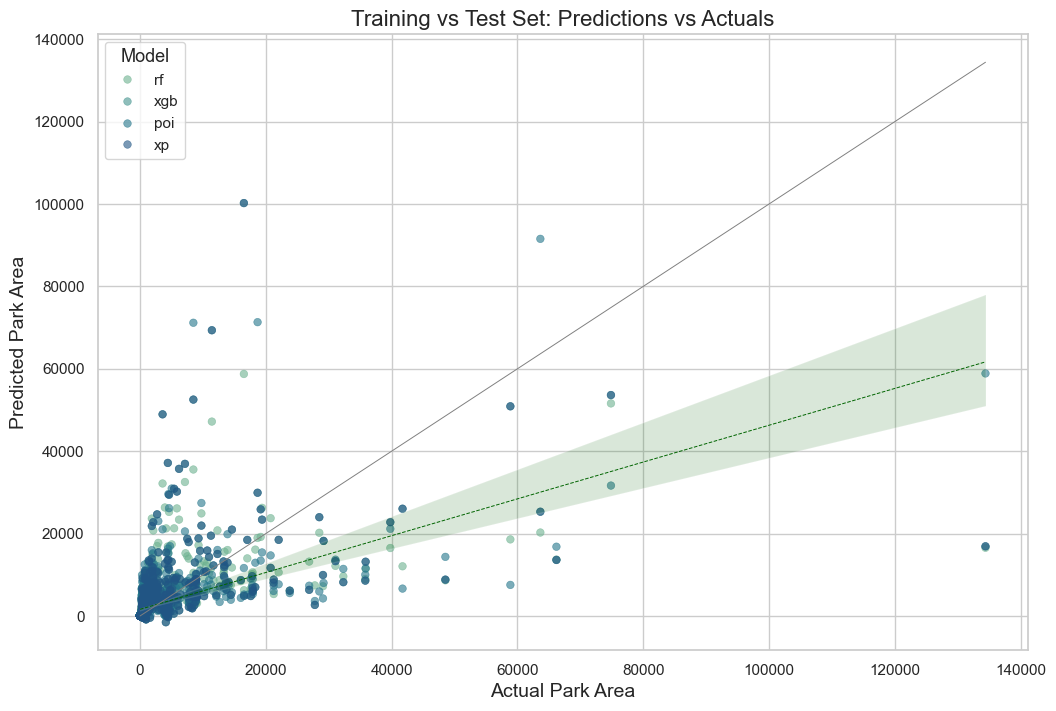

In [55]:
# 设置绘图风格和调色板
sns.set(style = 'whitegrid')

# 创建绘图对象
plt.figure(figsize = (12,8))

# 使用seaborn绘制点图
plot = sns.scatterplot(
    data = val_preds,
    x = 'true',
    y = 'pred',
    hue = 'model',
    palette = 'crest',
    alpha = 0.6,
    s = 30, # 散点大小
    edgecolor = None
)

# 添加回归线
sns.regplot(
    data = val_preds,
    x = 'true',
    y = 'pred',
    scatter = False,
    color = 'darkgreen',
    line_kws = {'linestyle':'--','linewidth':0.7}
)

# 添加对角线
plt.plot(
    [val_preds['true'].min(),val_preds['true'].max()],
    [val_preds['true'].min(),val_preds['true'].max()],
    linestyle = '-',
    color = 'grey',
    linewidth = 0.7
)

# 配置图表的标题和轴标签
plt.title("Training vs Test Set: Predictions vs Actuals", fontsize=16)
plt.xlabel("Actual Park Area", fontsize=14)
plt.ylabel("Predicted Park Area", fontsize=14)
plt.legend(title='Model', title_fontsize='13', fontsize='11')

# 显示图表
plt.show()


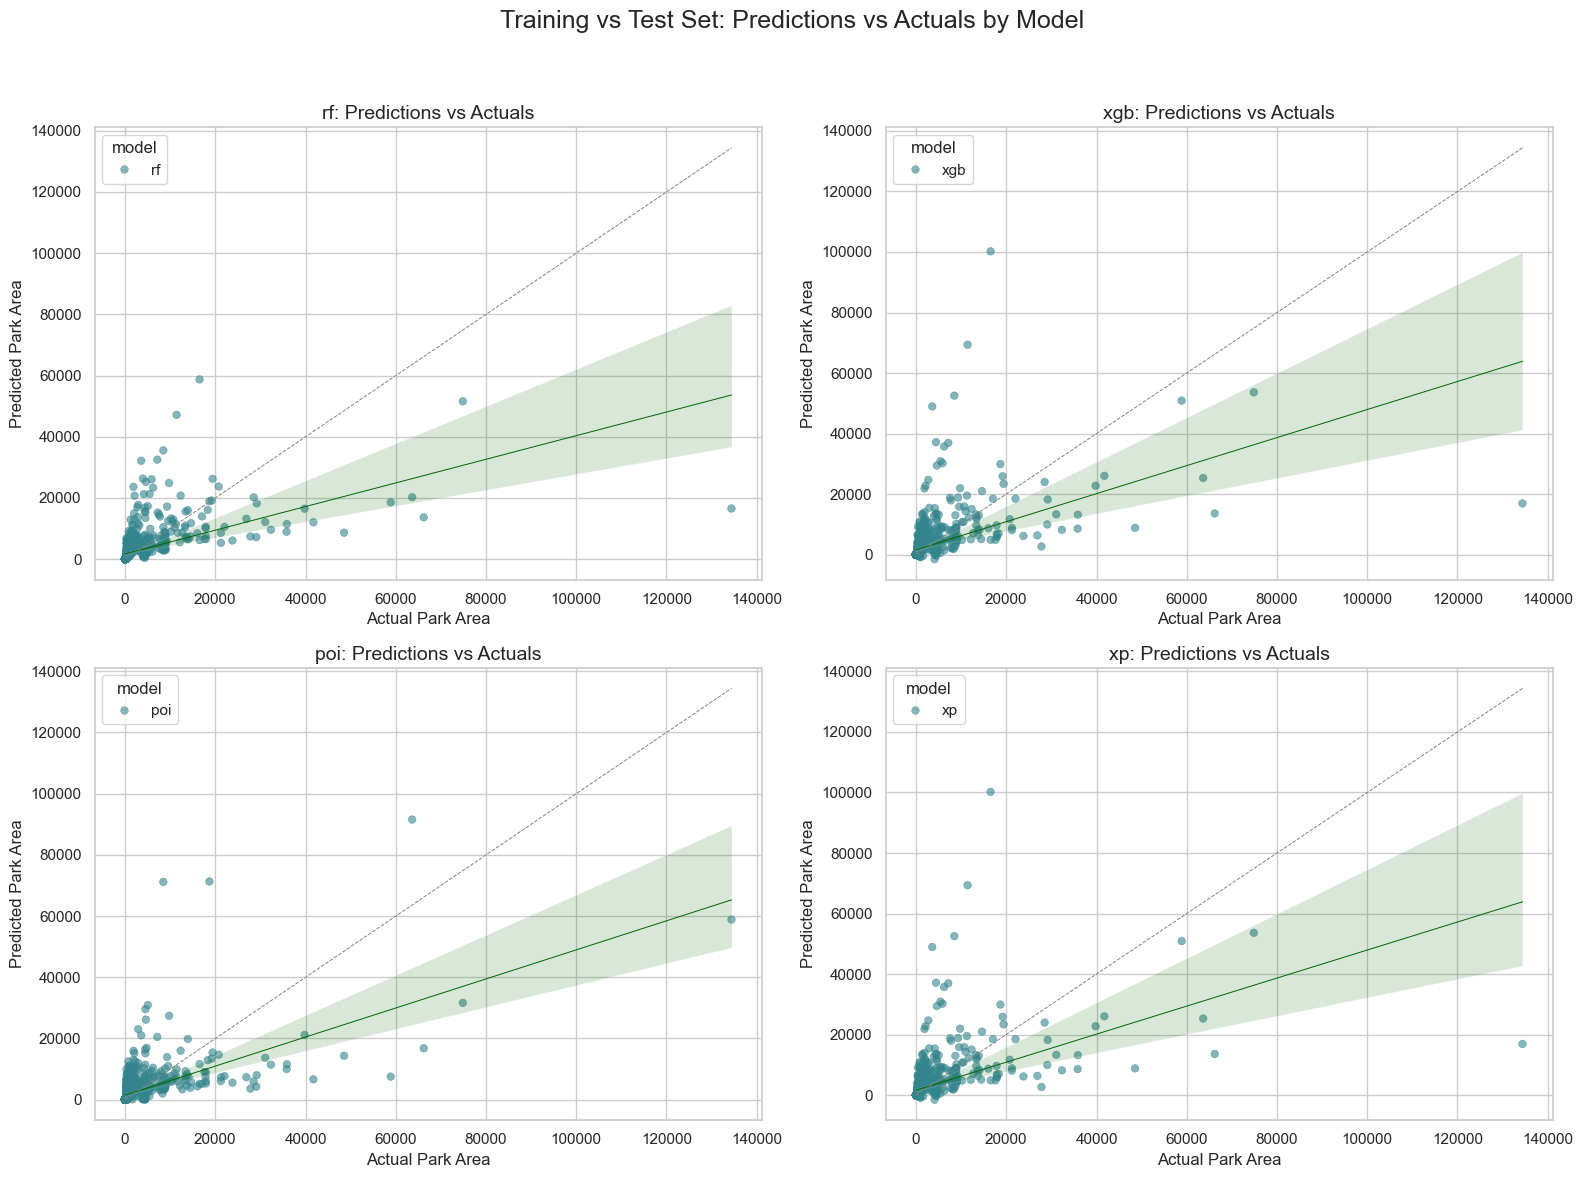

In [61]:
# 设置绘图风格和调色板
sns.set(style="whitegrid")
# 2*2的subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, model_name in zip(axes.flatten(), model_names):
    
    model_data = val_preds[val_preds['model'] == model_name]
    
    # 散点图
    sns.scatterplot(
        data=model_data,
        x='true',
        y='pred',
        ax=ax,
        alpha=0.6,
        palette = 'crest',
        hue = 'model',
        s=30,
        edgecolor=None
    )
    
    # 回归线
    sns.regplot(
        data=model_data,
        x='true',
        y='pred',
        scatter=False,
        color='darkgreen',
        line_kws={'linestyle': '-', 'linewidth': 0.7},
        ax=ax
    )
    
    # 添加一条对角线
    ax.plot(
        [model_data['true'].min(), model_data['true'].max()],
        [model_data['true'].min(), model_data['true'].max()],
        linestyle='--',
        color='grey',
        linewidth=0.7
    )
    
    # 设置标题，轴
    ax.set_title(f"{model_name}: Predictions vs Actuals", fontsize=14)
    ax.set_xlabel("Actual Park Area", fontsize=12)
    ax.set_ylabel("Predicted Park Area", fontsize=12)

plt.suptitle("Training vs Test Set: Predictions vs Actuals by Model", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [62]:
final_predictions_df.head()

,true,pred,model
840,0.0,0.000000,rf
2233,0.0,0.000000,rf
443,408.0,1309.668593,rf
836,0.0,0.000000,rf
2588,327.0,327.109039,rf


In [63]:
for model in model_names:
    column_name = f'{model}_prediction'
    # 找到每个模型对应的preds
    model_predictions = final_predictions_df[final_predictions_df['model']==model][['pred']]
    # 重命名
    model_predictions.rename(columns={'pred':column_name},inplace = True)
    # merge
    val_preds_df = val_preds_df.merge(model_predictions,left_index = True,right_index = True,how = 'left')
    # 填充
    val_preds_df[column_name] = val_preds_df[column_name].fillna(0)

val_preds_df 

,Unnamed: 0,geometry,grid_id,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,nearest_residential_distance,...,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE,TOTAL_AREA,TYPE,rf_prediction,xgb_prediction,poi_prediction,xp_prediction
0,0,"POLYGON ((-13607990.191 6023951.239, -13608158...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1,"POLYGON ((-13608506.816 6023962.863, -13608549...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,2,"POLYGON ((-13608682.765 6023966.612, -13608549...",2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,3,"POLYGON ((-13610206.446 6023341.9, -13610330.2...",3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,4,"POLYGON ((-13608853.099 6024384.238, -13608765...",4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,2672,"POLYGON ((-13622589.653 6062433.547, -13622542...",2672,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.437139,55.632614,0.437139
2673,2673,"POLYGON ((-13621158.074 6062738.471, -13621147...",2673,6.0,3.0,380.0,246.0,90.0,0.0,1011.930122,...,3.954203,11.427455,40.028232,8.941221,1806.0,2.0,11094.828194,4188.729004,5441.983528,4188.729004
2674,2674,"POLYGON ((-13622035.96 6062740.767, -13622149....",2674,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2675,2675,"POLYGON ((-13622184.874 6062741.252, -13622149...",2675,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.437139,55.632614,0.437139


In [64]:
# 获取MAE
for model_name in model_names:
    column_name = f'{model_name}_MAE'
    preds_name =  f'{model_name}_prediction'
    val_preds_df[column_name] = val_preds_df.apply(
            lambda x: mean_absolute_error([x['TOTAL_AREA']], [x[preds_name]]),
            axis=1
     )

In [65]:
val_preds_df

,Unnamed: 0,geometry,grid_id,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,nearest_residential_distance,...,TOTAL_AREA,TYPE,rf_prediction,xgb_prediction,poi_prediction,xp_prediction,rf_MAE,xgb_MAE,poi_MAE,xp_MAE
0,0,"POLYGON ((-13607990.191 6023951.239, -13608158...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,"POLYGON ((-13608506.816 6023962.863, -13608549...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,"POLYGON ((-13608682.765 6023966.612, -13608549...",2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,"POLYGON ((-13610206.446 6023341.9, -13610330.2...",3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,"POLYGON ((-13608853.099 6024384.238, -13608765...",4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,2672,"POLYGON ((-13622589.653 6062433.547, -13622542...",2672,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.437139,55.632614,0.437139,0.000000,0.437139,55.632614,0.437139
2673,2673,"POLYGON ((-13621158.074 6062738.471, -13621147...",2673,6.0,3.0,380.0,246.0,90.0,0.0,1011.930122,...,1806.0,2.0,11094.828194,4188.729004,5441.983528,4188.729004,9288.828194,2382.729004,3635.983528,2382.729004
2674,2674,"POLYGON ((-13622035.96 6062740.767, -13622149....",2674,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2675,2675,"POLYGON ((-13622184.874 6062741.252, -13622149...",2675,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.437139,55.632614,0.437139,0.000000,0.437139,55.632614,0.437139


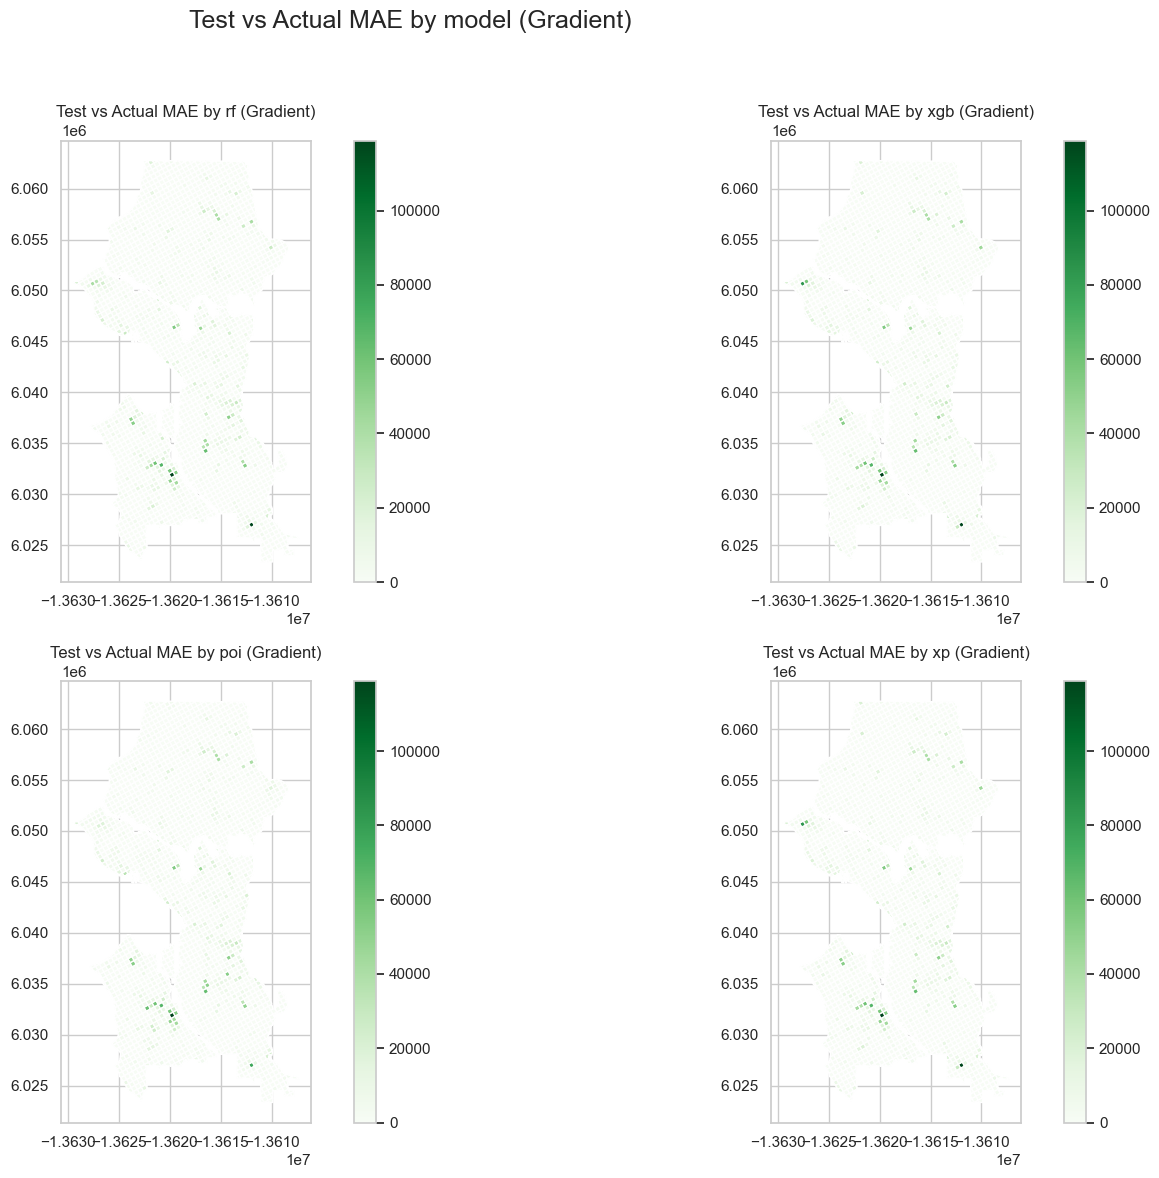

In [67]:
import matplotlib.pyplot as plt
import geopandas as gpd

# 使用matplotlib绘图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, model_name in zip(axes.flatten(), model_names):
    column_name = f'{model_name}_MAE'
    
    # 确保 'column_name' 存在于 DataFrame 中
    if column_name in val_preds_df.columns:
        # 使用MAE的渐变色绘制
        val_preds_df.plot(column=column_name, cmap='Greens', legend=True, ax=ax)
        ax.set_title(f"Test vs Actual MAE by {model_name} (Gradient)")
    else:
        ax.text(0.5, 0.5, f"Column {column_name} not found", fontsize=12, ha='center')

plt.suptitle("Test vs Actual MAE by model (Gradient)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


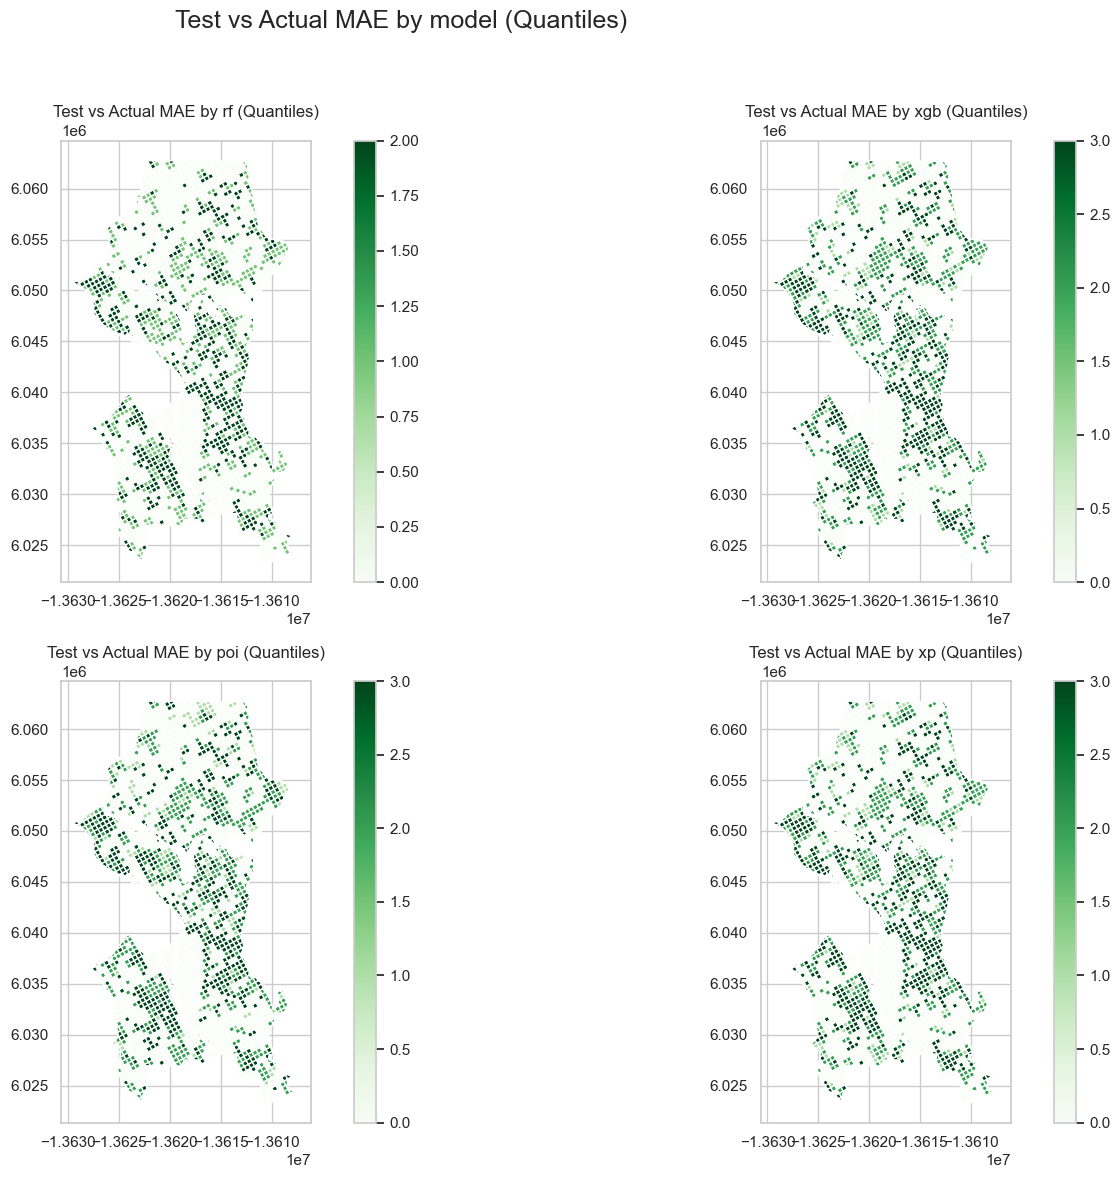

In [68]:
import matplotlib.pyplot as plt
import geopandas as gpd

# 使用matplotlib绘图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, model_name in zip(axes.flatten(), model_names):
    column_name = f'{model_name}_MAE_quantiles'
    MAE_name = f'{model_name}_MAE'
    val_preds_df[column_name] = pd.qcut(val_preds_df[MAE_name], 5, labels=False,duplicates='drop')
    val_preds_df.plot(column=column_name, cmap='Greens', legend=True, ax=ax)
    ax.set_title(f"Test vs Actual MAE by {model_name} (Quantiles)")

plt.suptitle("Test vs Actual MAE by model (Quantiles)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [69]:
# 保存RF模型

import pickle

# 保存模型到 .pkl 文件
with open('20251015_Best_Model.pkl', 'wb') as file:
    pickle.dump(rf_best_model, file)